# hw 6: estimators
learning objectives:
* solidify "what is an estimator"
* evaluate the effectiveness of an estimator computationally (through simulation)
* understand the notion of unbiasedness, consistency, and efficiency of an estimator and evaluate these qualities computationally (through simulation)

In [1]:
using StatsBase
using Random
using Statistics
using PyPlot
using PyCall

sns = pyimport("seaborn")
sns.set_context("talk");

┌ Info: Recompiling stale cache file C:\Users\cartemic\.julia\compiled\v1.2\StatsBase\EZjIG.ji for StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91]
└ @ Base loading.jl:1240


### what is the most important problem in your field?

(0) It is important to effectively communicate with people from different fields. Introduce yourself to someone in the class from a different field of study (someone you haven't met). Ask them, "what is the most important problem in your field of study?". Then, argue/explain what you think is the most important problem in *your* field of study.

Write the name of the student you spoke with and their field of study.

I'd also be interested to read about what you think is the most important problem in your field (a few sentences), but this is not required.

("field of study" can be as general as "chemistry" or as specific as "self-assembly of nanoparticles".)

I spoke with Heather Miller, whose field is humanitarian engineering

### counting
(1) A biologist takes a random sample of six fish from a lake. The lake has ten distinct species of fish. It is possible for the biologist to select more than one fish of any given species. e.g., one outcome is: one fish of species $X$, two fish of species $Y$, and four fish of species $Z$. How many different samples could the biologist draw from the lake?
* the sampling is done without replacement, but this is irrelevant since the lake contains more than six fish of each species
* the order in which the fish are sampled does not matter
* fish of a given species are indistinguishable

Essentially what this question comes down to is that we have 10 distinct bins (i.e. species), and we want to know how many ways we can split up 6 particles (samples) between them. Pretty neat how partitioning just kind of... works for multisets like that. Anyway, from our class notes there are ${n + k - 1 \choose k - 1}$ ways to partition $n$ particles into $k$ bins. Interestingly, there are also ${n + k - 1 \choose n}$ ways to partition the same $n$ particles into the same $k$ bins because

$${{n + k - 1} \choose k - 1} = \frac{(n + k - 1)!}{(k-1)!(n+k-1-k+1)!} = \frac{(n+k-1)!}{(k-1)!n!}$$
is equivalent to
$${n + k - 1 \choose n} = \frac{(n + k - 1)!}{n!(n+k-1-n)!} = \frac{(n+k-1)!}{n!(k-1)!}$$
which means that, generally, $${m + n \choose m} = {m + n \choose n}$$ which is pretty cool.

In [2]:
function n_choose_k(n::Int, k::Int)
    # using multiple divide operations to avoid overflow for larger values
    # of n, k
    return Int(factorial(n) / factorial(k) / factorial(n - k))
end
@assert n_choose_k(7, 5) == 21

sample_size = 6
num_species = 10

n = sample_size + num_species - 1
k = sample_size

fish_partitions = n_choose_k(n, k)
println("There are $fish_partitions samples of fish that the biologist could collect.")

There are 5005 samples of fish that the biologist could collect.


### capture, mark, release, recapture

In ecology, one wishes to estimate the size of a population (e.g. turtles). It is too costly and impractical to count *every* member of a population. One strategy is to:
1. capture a random sample from the population, without replacement
2. mark/tag each member of this random sample
3. release the marked sample back into the population
4. after sufficient time has passed, recapture another sample
5. count the number of marked members from the recaptured sample

We assume that:
* when the captured and marked sample is released back into the wild, they randomly (homogenously) mix with the rest of the (unmarked) population before we recapture
* marking a member of the population does not change its likelihood of being recaptured
* the time between capture/mark/release and recapture/count is short enough to neglect deaths, births, and migration out of the population

define the variables:
* $n$: the total number of turtles in the population (unknown)
* $k$: number of turtles captured, marked, and released in the first phase
* $k_r$: number of turtles recaptured
* $m$: the number of recaptured turtles that had marks on them

##### Lincoln-Petersen estimator
A very intuitive estimator is found by imposing that the proportion found marked in the recaptured sample is equal to the proportion of the population that was captured/marked/released in the first phase.

\begin{equation}
\frac{k}{n}=\frac{m}{k_r}
\end{equation}

giving the Lincoln-Petersen estimator for the population size $n$:
\begin{equation}
\hat{n} = \frac{k k_r}{m}
\end{equation}

##### Chapmen estimator
Chapmen derived a different estimator that we will compare to the Lincoln-Petersen estimator below.
\begin{equation}
\hat{n} = \frac{(k + 1) (k_r +1)}{m+1} - 1
\end{equation}

#### estimating the population of turtles on a small island
We wish to estimate the population of turtles on a small island by a capture, mark, release, and recapture strategy.

(2) create a mutable data structure `Turtle` that represents a turtle in the population. It should have a single attribute, `marked`, that indicates whether it has been marked or not.

In [3]:
mutable struct Turtle
    marked::Bool
    
    function Turtle()
        # new turtles aren't marked
        new(false)
    end
end

@assert !Turtle().marked

(3) write a function `create_population(nb_turtles::Int)` that creates a population of `nb_turtles` unmarked `Turtle`s. return the turtles as an `Array{Turtle}`.

In [4]:
function create_population(nb_turtles::Int)
    return [Turtle() for _ in 1:nb_turtles]
end

@assert create_population(4) isa Array{Turtle}

(4) write a function `count_marked(turtles::Array{Turtle})` that takes in a population of turtles and returns the number of these turtles that are marked. 

```julia
turtles = create_population(500)
count_marked(turtles) # should return zero
```

In [5]:
function count_marked(turtles::Array{Turtle})
    sum([t.marked for t in turtles])
end

turtles = create_population(500)
@assert count_marked(turtles) == 0
[turtles[i].marked = true for i in 1:5]
@assert count_marked(turtles) == 5
# put the test turtles back in the pond
[t.marked = false for t in turtles];

(5) write a function `capture_mark_release!` that takes in two arguments:
* `turtles::Array{Turtle}` the population of turtles
* `nb_capture_mark_release::Int` the number of turtles to randomly capture (select without replacement) and mark

and modifies the `marked` attribute of `nb_capture_mark_release` randomly selected turtles in `turtles` to denote that they have been marked. think about why the function has an `!`.

```julia
turtles = create_population(500)
capture_mark_release!(turtles, 45)
count_marked(turtles) # should return 45
```

In [6]:
function capture_mark_release!(
        turtles::Array{Turtle},
        nb_capture_mark_release
    )
    selected = sample(turtles, nb_capture_mark_release, replace=false)
    
    for t in selected
        t.marked = true
    end
end

turtles = create_population(100)
capture_mark_release!(turtles, 30)
@assert count_marked(turtles) == 30

(6) write a function `recapture(turtles::Array{Turtle}, nb_recapture::Int)` that returns a random sample (without replacement) of `nb_recapture` turtles from `turtles` in the form of an `Array{Turtle}`.

```julia
turtles = create_population(500)
capture_mark_release!(turtles, 45)
recaptured_turtles = recapture(turtles, 50) # should return Array{Turtle} with 50 elements
```

In [7]:
function recapture(turtles::Array{Turtle}, nb_recapture::Int)
    return sample(turtles, nb_recapture, replace=false)
end

turtles = create_population(500)
capture_mark_release!(turtles, 45)
@assert length(recapture(turtles, 50)) == 50

(7) write two functions, one for each estimator:

* `chapman_estimator(nb_capture_mark_release::Int, nb_recapture::Int, nb_marked_in_recaptured::Int)`
* `lincoln_petersen_estimator(nb_capture_mark_release::Int, nb_recapture::Int, nb_marked_in_recaptured::Int)`

that each take in the entire population of turtles (marked and unmarked), `turtles`, and the array of recaptured turtles, `recaptured_turtles`, and returns the respective estimate $\hat{n}$ of the number of turtles. here, `nb_capture_mark_release` is $k$, `nb_recapture` is $k_r$, and `nb_marked_in_recaptured` is $m$.

In [8]:
function chapman_estimator(
        nb_capture_mark_release::Int,
        nb_recapture::Int,
        nb_marked_in_recaptured::Int
)
    return (nb_capture_mark_release + 1) * (nb_recapture + 1) / (nb_marked_in_recaptured + 1) - 1
end

chapman_estimator (generic function with 1 method)

In [9]:
function lincoln_petersen_estimator(
        nb_capture_mark_release::Int,
        nb_recapture::Int,
        nb_marked_in_recaptured::Int
)
    return nb_capture_mark_release * nb_recapture / nb_marked_in_recaptured
end

lincoln_petersen_estimator (generic function with 1 method)

(8) write a function `sim_capture_mark_release_recapture` that takes in:

* `nb_turtles::Int` $=n$
* `nb_capture_mark_release::Int` $=k$
* `nb_recapture::Int` $=k_r$
* `estimator::Function` either `chapman_estimator` or `lincoln_peterson_estimator` that you wrote above

and returns $\hat{n}$, the estimate of the number of turtles in this simulation.

use all of the functions you wrote above.

```julia
nb_turtles = 200
nb_capture_mark_release = 50
nb_recapture = 42
estimator = lincoln_petersen_estimator
n̂ = sim_capture_mark_release_recapture(
    nb_turtles,
    nb_capture_mark_release,
    nb_recapture,
    estimator
)
```

In [10]:
function sim_capture_mark_release_recapture(
        nb_turtles::Int,
        nb_capture_mark_release::Int,
        nb_recapture::Int,
        estimator::Function
    )
    turtles = create_population(nb_turtles)
    capture_mark_release!(turtles, nb_capture_mark_release)
    new_turtles = recapture(turtles, nb_recapture)
    nb_marked_in_recaptured = count_marked(new_turtles)
    estimator(nb_capture_mark_release, nb_recapture, nb_marked_in_recaptured)
end

sim_capture_mark_release_recapture (generic function with 1 method)

(9) evaluate/compare the biasedness of the Chapman and Lincoln-Peterson estimators by plotting the distribution of $\hat{n}$ over many capture, mark, release, recapture simulations. Label which histogram corresponds to which estimator (in a legend if in the same histogram panel or in a title if in two subplots). plot as a vertical line the true number of turtles for comparison. print off the average and standard deviation of $\hat{n}$ over the simulations.

Chapman
avg ̂n:	201.0473060593354
std ̂n:	51.51012280988463

Lincoln-Petersen
avg ̂n:	212.82923064835063
std ̂n:	60.628303924892585


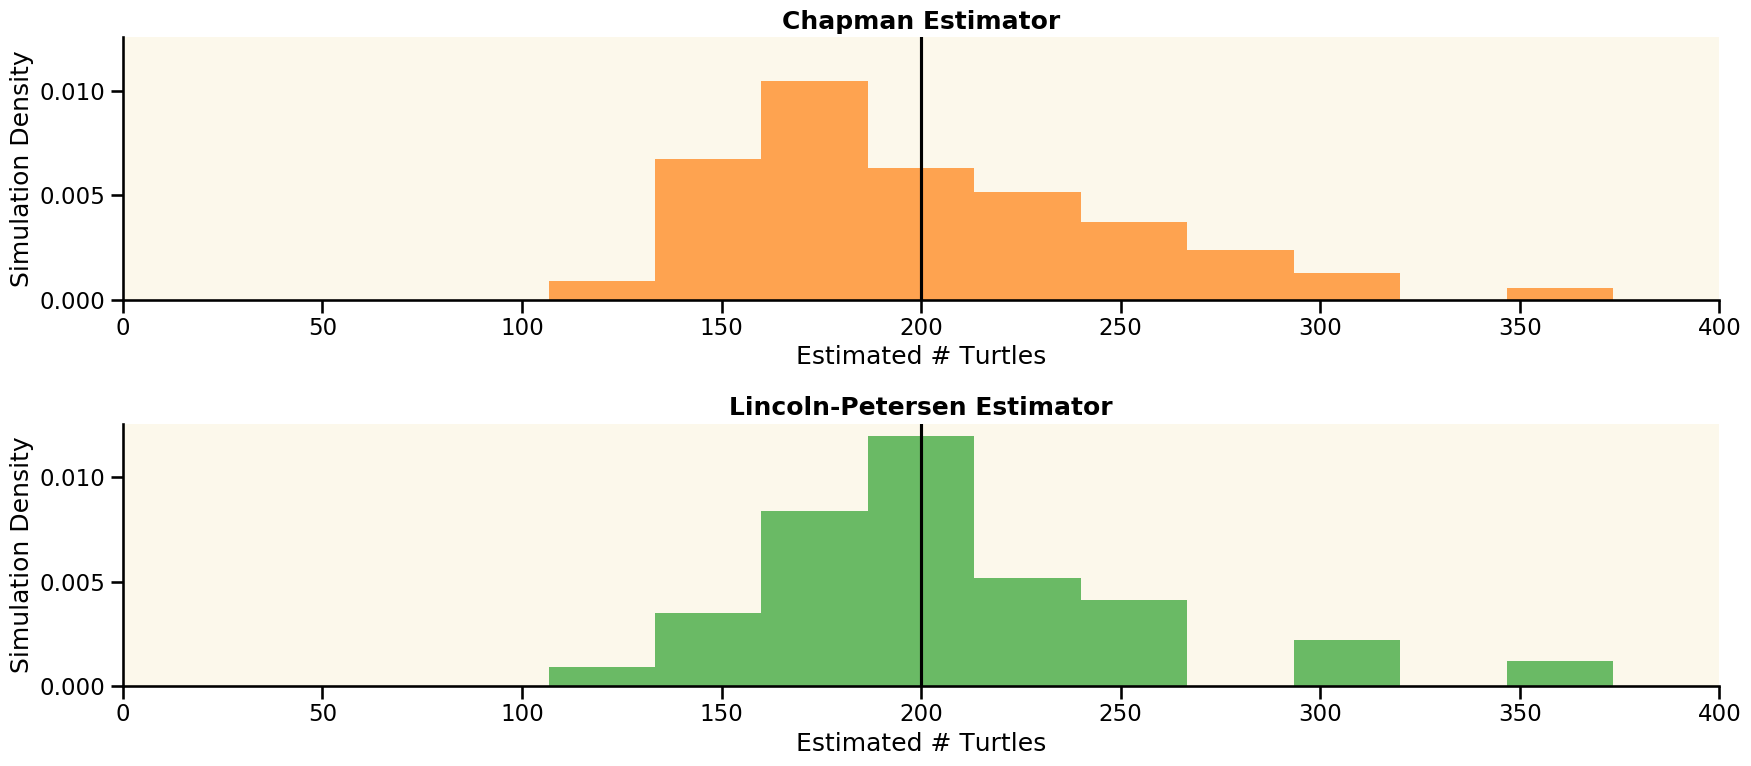



least biased:	Chapman
most efficient:	Chapman


In [11]:
nb_turtles = 200
nb_capture_mark_release = 50
nb_recapture = 42
sims_range = 1:5000 # number of simulations
face_color = "#fcf8eb"

estimators = Dict(
    "Chapman" => Dict(
        "function" => chapman_estimator,
        "̂n" => [NaN for _ in sims_range]
    ),
    "Lincoln-Petersen" => Dict(
        "function" => lincoln_petersen_estimator,
        "̂n" => [NaN for _ in sims_range]
    )
)

fig, ax = subplots(2, 1, figsize=(18, 8), sharey=true)
bins = range(0, stop=2*nb_turtles, length=16)

est_keys = collect(keys(estimators))
num_keys = length(est_keys)
avgs = [NaN for _ in 1:num_keys]
stds = [NaN for _ in 1:num_keys]
for (plot, name) in enumerate(est_keys)
    for i in sims_range
        estimators[name]["̂n"][i] = sim_capture_mark_release_recapture(
            nb_turtles,
            nb_capture_mark_release,
            nb_recapture,
            estimators[name]["function"]
        )
    end
    ax[plot].hist(
        estimators[name]["̂n"],
        alpha=0.7,
        color="C$plot",
        label=name,
        bins=bins,
        density=true
    )
    ax[plot].axvline(nb_turtles, color="k")
    ax[plot].set_xlabel("Estimated # Turtles")
    ax[plot].set_ylabel("Simulation Density")
    ax[plot].set_title("$name Estimator", weight="bold")
    ax[plot].set_xlim([0, 2*nb_turtles])
    ax[plot].set_facecolor(face_color)
    avgs[plot] = mean(estimators[name]["̂n"])
    stds[plot] = std(estimators[name]["̂n"])
    println(name)
    println("=" ^ length(name))
    println("avg ̂n:\t", avgs[plot])
    println("std ̂n:\t", stds[plot])
    println()
end
fig.tight_layout()
sns.despine()

println()
println("least biased:\t", est_keys[argmin(avgs .- nb_turtles)])
println("most efficient:\t", est_keys[argmin(stds)])

(10) comment on which estimator, Chapman or Lincoln-Petersen, that appears to be most unbiased.

Based on the above simulations, the Chapman estimator appears unbiased, as well as more efficient.

(11) evaluate the consistency of the Lincoln-Petersen estimator by plotting the simulated distribution of $\hat{n}$ for several different values of `nb_recapture`. Use 10000 simulations for each value of `nb_recapture`.

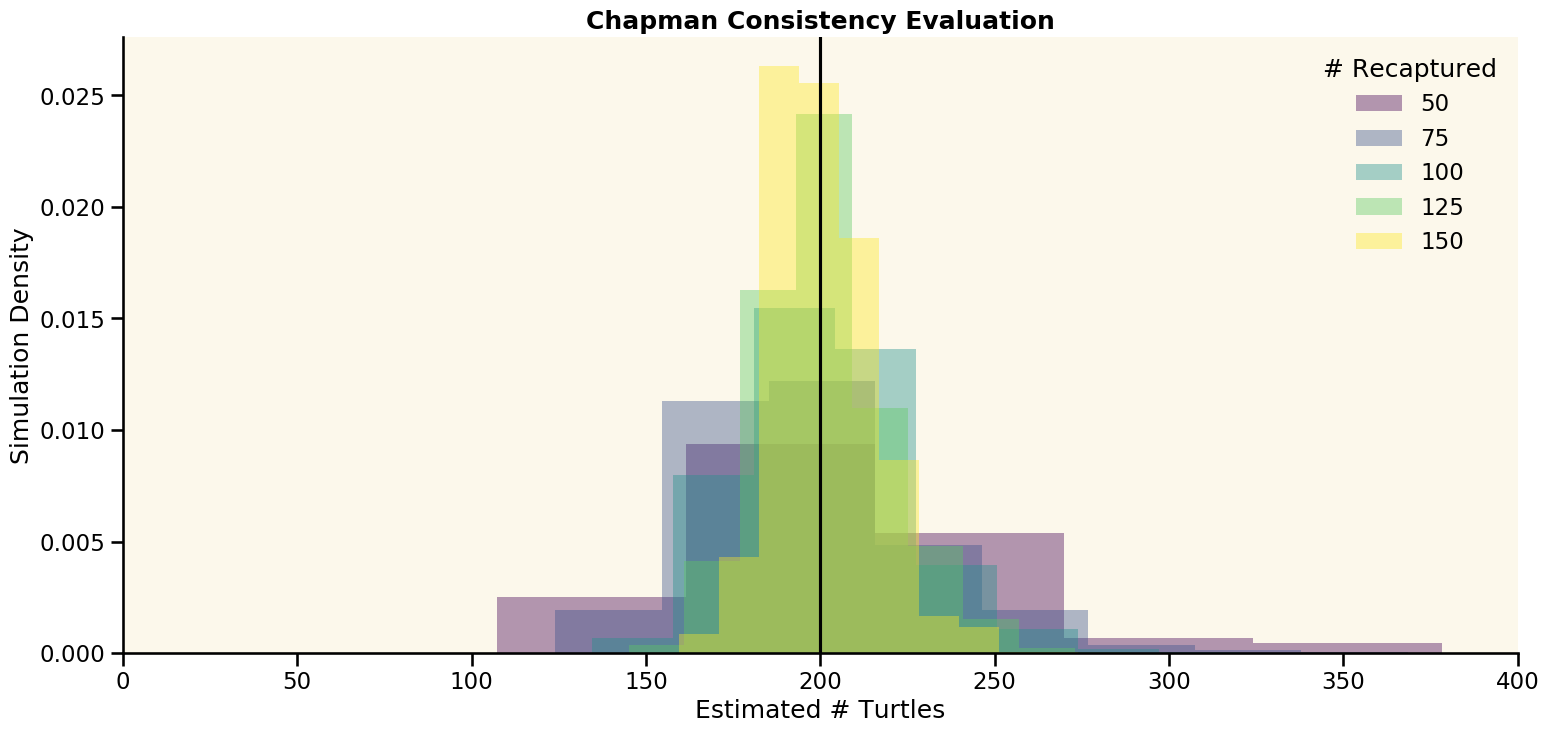

In [12]:
recapture_range = 50:25:150
fig, ax = subplots(1, 1, figsize=(18, 8))
bins = range(0, stop=2*nb_turtles, length=16)
sims_range = 1:10000

color_norm = PyPlot.matplotlib.colors.Normalize(vmin=50, vmax=150)
kr_to_color = PyPlot.cm.ScalarMappable(
    norm=color_norm,
    cmap=get_cmap("viridis")
).to_rgba

for nb_recapture in recapture_range
    n = [sim_capture_mark_release_recapture(
            nb_turtles,
            nb_capture_mark_release,
            nb_recapture,
            chapman_estimator
        ) for _ in sims_range]
    ax.hist(
        n,
        label=nb_recapture,
        alpha=0.4, 
        density=true,
        color=kr_to_color(nb_recapture)
    )
end
ax.axvline(nb_turtles, color="k")
ax.set_xlabel("Estimated # Turtles")
ax.set_ylabel("Simulation Density")
ax.set_title("Chapman Consistency Evaluation", weight="bold")
ax.legend(title="# Recaptured", frameon=false)
ax.set_xlim([0, 2*nb_turtles])
ax.set_facecolor(face_color)
sns.despine()